Creating a Simple Graph with Langgraph

In [150]:
# Defining the State
from typing import TypedDict

class State(TypedDict):
    graph_state:str


In [102]:
# Defining the nodes

def node_1(state:State):
    print('---Node-1---')
    updated_state = {'graph_state':state['graph_state'] + ' I am'}
    print(updated_state)
    return updated_state

def node_2(state:State):
    print('---Node-2---')
    return {'graph_state':state['graph_state'] + ' very happy'}

def node_3(state:State):
    print('---Node-3---')
    return {'graph_state':state['graph_state'] + ' very sad'}




In [103]:
# Defining the conditional edge function
import random
from typing import Literal

def decide_mood(state:State) -> Literal["node_2","node_3"]:

    user_input = state['graph_state']

    # Creating a 50% probability of choosing a path
    if random.random() < 0.5:
        return "node_2"
    else:
        return "node_3"


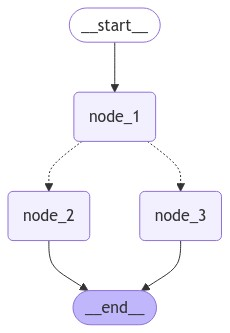

In [151]:
# Building the graph
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display


# Initiate the graph builder object
builder = StateGraph(State)

# Building the graph
# Add nodes
# builder.add_node(node_name,node_func)

builder.add_node("node_1",node_1)
builder.add_node("node_2",node_2)
builder.add_node("node_3",node_3)

# Add edges
# builder.add_edge(start_entity,end_entity)
# builder.add_conditional_edges(start_entity,conditional func)

builder.add_edge(START,'node_1')
builder.add_conditional_edges('node_1',decide_mood)
builder.add_edge('node_2',END)
builder.add_edge('node_3',END)

# Compile the graph
graph = builder.compile()

# Visualizing the graph
display((Image(graph.get_graph().draw_mermaid_png())))


In [153]:
# Executing the graph
graph.invoke({'graph_state':"Fiddler here!"})

---Node-1---
{'graph_state': 'Fiddler here! I am'}
---Node-3---


{'graph_state': 'Fiddler here! I am very sad'}

In [159]:
# Reducers

# Define a messages state
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list,add_messages]




In [160]:
# Creating a graph with a tool enabled LLM
# Creating the state
from langgraph.graph import MessagesState

# Define the state
class State(MessagesState):
    pass

# Creating a simple multiplication tool
from langchain.tools import StructuredTool

# Defining the tool function
def multiply(a:int,b:int):
    """
    Multiply two numbers a and b

    """
    return a*b

# Assign it as a tool
multiplier = StructuredTool.from_function(func = multiply)

# Creating an llm runnable

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = 'gpt-3.5-turbo')

# Binding it with tools

# Creating the tools list
tools = [multiplier]

# Binding it to the LLM
llm_with_tools = llm.bind_tools(tools=tools)


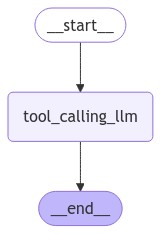

In [161]:
# Define the node function for llm
def tool_calling_llm(state:MessagesState):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}

builder = StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_edge(START,'tool_calling_llm')
builder.add_edge('tool_calling_llm',END)
graph = builder.compile()


# Visualize
display(Image(graph.get_graph().draw_mermaid_png()))

In [164]:
# Execute 
initial_state = {'messages':'Hi, how are you?'}
response = graph.invoke(initial_state)

In [165]:
response

{'messages': [HumanMessage(content='Hi, how are you?', additional_kwargs={}, response_metadata={}, id='d525df44-80a7-4afa-9238-3577dcd932ca'),
  AIMessage(content="Hello! I'm here and ready to assist you. How can I help you today?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 54, 'total_tokens': 73, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-85fe8734-302e-43d1-8f84-70b98a64528d-0', usage_metadata={'input_tokens': 54, 'output_tokens': 19, 'total_tokens': 73, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})]}

Router


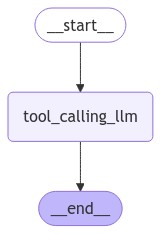

In [172]:
# Creating the state
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define the state
class State(MessagesState):
    pass


# Define the node function for llm
def tool_calling_llm(state:MessagesState):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}

# Instantiating the builder object
builder = StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)

# The tool node here will take in input the tool call
# and provide the output as per the multiplier tool 

builder.add_node('tools',ToolNode(tools))

builder.add_edge(START,'tool_calling_llm')
builder.add_conditional_edges('tool_calling_llm',
                              tools_condition)
builder.add_edge('tools',END)


# Compiling graph
graph_router = builder.compile()


# Visualize
display(Image(graph.get_graph().draw_mermaid_png()))


In [178]:
from langchain_core.messages import HumanMessage

initial_state = {'messages': HumanMessage(content="Multiply 2 and 5")}
response = graph_router.invoke(initial_state)
for r in response['messages']:
    r.pretty_print()



================================ Human Message =================================

Multiply 2 and 5
================================== Ai Message ==================================
Tool Calls:
  multiply (call_XIHTAeiPVsKql2ALX1ZpUpZ6)
 Call ID: call_XIHTAeiPVsKql2ALX1ZpUpZ6
  Args:
    a: 2
    b: 5
================================= Tool Message =================================
Name: multiply

10


ReAct Agent


In [182]:
# Defining the tools
from langchain.tools import StructuredTool

def multiply(a:int, b:int) -> int:
    """
    Multiply a and b

    """
    return a*b

def add(a:int, b:int) -> int:
    """
    Adds a and b

    """
    return a+b

def divide(a:int, b:int) -> int:
    """
    Divide a and b

    """
    return a/b

multiplier = StructuredTool.from_function(func = multiply)
adder = StructuredTool.from_function(func = add)
divider = StructuredTool.from_function(func = divide)

tools = [multiplier,adder,divider]

llm = ChatOpenAI(model = 'gpt-3.5-turbo')

llm_with_tools = llm.bind_tools(tools)

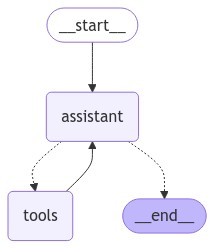

In [183]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System Message
sys_msg = SystemMessage(content = "You are a helpful assistant tasked with performing arithmetic on a set of inputs")


# Node function for LLM
def assistant(state:MessagesState):
    response = llm_with_tools.invoke([sys_msg] + state['messages'])
    return {'messages': [response]}

from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

# Builder object
builder = StateGraph(MessagesState)


# Adding nodes
builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))

# Adding edges
builder.add_edge(START,'assistant')
builder.add_conditional_edges(
    "assistant",
    tools_condition
)

# Feedback edge
builder.add_edge('tools','assistant')

# Compile
react_graph = builder.compile()

# Visualize
display(Image(react_graph.get_graph().draw_mermaid_png()))






In [190]:
# Execute
initial_state = {'messages':HumanMessage(content = 'Multiply 2 and 3 and then add 10 to it and then divide it by 2')}
response = react_graph.invoke(initial_state)

for r in response['messages']:
    r.pretty_print()


================================ Human Message =================================

Multiply 2 and 3 and then add 10 to it and then divide it by 2
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ErlRNqvuZv88ZPoqMNjjrTt2)
 Call ID: call_ErlRNqvuZv88ZPoqMNjjrTt2
  Args:
    a: 2
    b: 3
  add (call_iV7CEQE32d2Jeac5d2iMXNRB)
 Call ID: call_iV7CEQE32d2Jeac5d2iMXNRB
  Args:
    a: 6
    b: 10
  divide (call_hiAHTbXBb2RanL0CO49ldhG4)
 Call ID: call_hiAHTbXBb2RanL0CO49ldhG4
  Args:
    a: 16
    b: 2
================================= Tool Message =================================
Name: multiply

6
================================= Tool Message =================================
Name: add

16
================================= Tool Message =================================
Name: divide

8.0
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6. 

Adding 10 to 6 gives 16

In [293]:
import os
from dotenv import load_dotenv

load_dotenv()

True

Setting up LangSmith:

LangSmith is an all-in-one developer platform for every step of the LLM-powered application lifecycle, whether you’re building with LangChain or not.
Debug, collaborate, test, and monitor your LLM applications

In [313]:
# Setting up LangSmith
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_API_KEY'] = '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'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'

In [314]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()
llm.invoke("Hello, world!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 11, 'total_tokens': 20, 'prompt_tokens_details': {'cached_tokens': 0}, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-698a0484-026f-4d29-a527-98eaf1490db6-0', usage_metadata={'input_tokens': 11, 'output_tokens': 9, 'total_tokens': 20, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

ReAct Agent with Memory

In [295]:
# Defining the tools
from langchain.tools import StructuredTool
from langchain_openai import ChatOpenAI

def multiply(a:int,b:int) -> int:
    """
    Multiply two integers a and b

    """
    return a*b

def add(a:int,b:int) -> int:
    """
    Add two integers a and b 

    """
    return a+b

def divide(a:int,b:int) -> int:
    """
    Divide two integers a and b 

    """
    return a/b

# Assigning the tools
multiplier = StructuredTool.from_function(func=multiply)
adder = StructuredTool.from_function(func=add)
divider = StructuredTool.from_function(func=divide)


#Creating the tools list
tools = [multiplier,adder,divider]

# Binding tools to LLM
llm = ChatOpenAI(model='gpt-3.5-turbo')
llm_with_tools = llm.bind_tools(tools)

In [296]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage

# Defining the state
class State(MessagesState):
    pass

# System Message
sys_msg = SystemMessage(content = """You're a helpful assistant 
                        tasked with performing arithmetic on a set 
                        of inputs""" )

# Defining the assistant node function
def assistant(state:MessagesState):
    return {'messages': [llm_with_tools.invoke([sys_msg]+state['messages'])]}



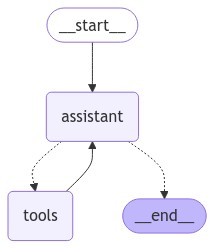

In [297]:
from langgraph.prebuilt import tools_condition,ToolNode

# Initiating the builder object
builder = StateGraph(MessagesState)

# Adding nodes and egdes
builder.add_node('assistant',assistant)
builder.add_node('tools',ToolNode(tools))
builder.add_edge(START,'assistant')
builder.add_conditional_edges('assistant',
                              tools_condition)
builder.add_edge('tools','assistant')

# Compiling it
react_graph = builder.compile()

# Visualize
display(Image(react_graph.get_graph().draw_mermaid_png()))


In [298]:
# Execute it 
initial_state = {'messages' : [HumanMessage(content = "Multiply 3 and 6")]}
output = react_graph.invoke(initial_state)
for o in output['messages']:
    o.pretty_print()

================================ Human Message =================================

Multiply 3 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_tEs3ujS42a6iRLpW0BaLM7J9)
 Call ID: call_tEs3ujS42a6iRLpW0BaLM7J9
  Args:
    a: 3
    b: 6
================================= Tool Message =================================
Name: multiply

18
================================== Ai Message ==================================

The result of multiplying 3 and 6 is 18.


In [315]:
# Now querying the graph again based on earlier execution
initial_state = {'messages' : [HumanMessage(content = "Now, add 2 to it")]}
output = react_graph.invoke(initial_state)
for o in output['messages']:
    o.pretty_print()

================================ Human Message =================================

Now, add 2 to it
================================== Ai Message ==================================
Tool Calls:
  add (call_sfIT5MZ9T6zG4602NMz6kK7q)
 Call ID: call_sfIT5MZ9T6zG4602NMz6kK7q
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The result of adding 2 to 5 is 7.


##### Adding memory persistence to our graph

LangGraph uses a checkpointer to save the state after each node or step. We are going to use the MemorySaver checkpointer which is an in-memory key value store for storing graph states.


In [320]:
# Adding checkpointer to the graph
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

# Adding the checkpointer feature to our graph
react_graph_memory = builder.compile(checkpointer = memory)

In [323]:
# Configuring a thread
config = {'configurable': {'thread_id': '3'}}

# Input for execution
input = HumanMessage(content = 'Multiply 3 and 6')

# Execution with memory enabled
output = react_graph_memory.invoke({'messages':input},config)
for o in output['messages']:
    o.pretty_print()

================================ Human Message =================================

Multiply 3 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_3QMDaex3ZAYQu4UkofLGiZ27)
 Call ID: call_3QMDaex3ZAYQu4UkofLGiZ27
  Args:
    a: 3
    b: 6
================================= Tool Message =================================
Name: multiply

18
================================== Ai Message ==================================

The result of multiplying 3 and 6 is 18.


In [324]:
# Now, querying again on top of the earlier execution
# Input for execution
input = HumanMessage(content = 'Now, add 2 to it')

# Execution
output = react_graph_memory.invoke({'messages':input},config)
for o in output['messages']:
    o.pretty_print()

================================ Human Message =================================

Multiply 3 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_3QMDaex3ZAYQu4UkofLGiZ27)
 Call ID: call_3QMDaex3ZAYQu4UkofLGiZ27
  Args:
    a: 3
    b: 6
================================= Tool Message =================================
Name: multiply

18
================================== Ai Message ==================================

The result of multiplying 3 and 6 is 18.
================================ Human Message =================================

Now, add 2 to it
================================== Ai Message ==================================
Tool Calls:
  add (call_hHhmUL9A5l7svvuINL0LGc6P)
 Call ID: call_hHhmUL9A5l7svvuINL0LGc6P
  Args:
    a: 18
    b: 2
================================= Tool Message =================================
Name: add

20
================================== Ai Message ==================================

Th

In [325]:
input = HumanMessage(content = 'Now, multiply that by 0')

# Execution
output = react_graph_memory.invoke({'messages':input},config)
for o in output['messages']:
    o.pretty_print()

================================ Human Message =================================

Multiply 3 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (call_3QMDaex3ZAYQu4UkofLGiZ27)
 Call ID: call_3QMDaex3ZAYQu4UkofLGiZ27
  Args:
    a: 3
    b: 6
================================= Tool Message =================================
Name: multiply

18
================================== Ai Message ==================================

The result of multiplying 3 and 6 is 18.
================================ Human Message =================================

Now, add 2 to it
================================== Ai Message ==================================
Tool Calls:
  add (call_hHhmUL9A5l7svvuINL0LGc6P)
 Call ID: call_hHhmUL9A5l7svvuINL0LGc6P
  Args:
    a: 18
    b: 2
================================= Tool Message =================================
Name: add

20
================================== Ai Message ==================================

Th